# EDA for US Census data

In [ ]:
import re
from summarytools import dfSummary
from janitor import clean_names
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# load feature names from metadata
metadata_file = open('./data/census_income_metadata.txt', 'r')
metadata_lines = metadata_file.readlines()
columns = [re.findall(r"(\b[a-z\s'1-9-]+\b):", line)[0] for line in metadata_lines[142:]]
columns.append('income_threshold')

# load data and format cols
data = (
	pd.read_csv('data/census_income_learn.csv', names=columns, index_col=False)
	.pipe(clean_names)
	.assign(income_threshold=lambda x: np.where(x['income_threshold'] == ' 50000+.', 1, 0))
)

dfSummary(data)


No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,age[int64],Mean (sd) : 34.5 (22.3)min < med < max:0.0 < 33.0 < 90.0IQR (CV) : 35.0 (1.5),91 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOnRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjEwLjAsIGh0dHBzOi8vbWF0cGxvdGxpYi5vcmcvlHJYcgAAAAlwSFlzAAAPYQAAD2EBqD+naQAAAp5JREFUeJzt3d2K2kAYgOFv6ipRIUEseuYNFHrgoRfRi+0lVPAKvAPPhCAR0w3GmJ5sCwtt12RmNvNl3+c8OpDXIT+TaOq6FiB0n7oeAPCIp64H4IsxZiwiI4uPuNZ1/exqPLDzZqiWO7yTnW2MGc/n829xHM/afsb5fD4ZY74Taxj+G6rtDu9wZ4/iOJ5tNpvnJEmKphtnWRZtt9tFmqafjTHnFt/PbOzYWzNq6x2eZVm02+1maZqORKSTnZYkSbFYLH423S7P82FZll9Xq9VgMBg0Dp3Z2L2HjlHb7vCqqmIRiY0xjQf2opOZ6Xq9PkVRNFmv18VyuTw12TaEH2gfeTuZsp2VRLqfmabTaasfqIiMnQ/mg/MWqs2sJMLMhNe8X56ymJVEmJnwggv+UIFQoQKhQgVChQqEChWCXpRSVdVQ2t0wiO/3+9DDkNCRYEO1uWFQlmVUVdWXoih+iEjbS2MISLCh2twwOBwOs/1+P7ndbgNf48P7CjbU39rcMDidTtwo6JngQ9XI4thahCWCf0WojrFE0A9CdYwlgn4QqicsEXSLC/5QgVChAqFCBUKFCoQKFQgVKhAqVCBUqECoUIFQoQKhQgVChQosSgmM5VpWkZ6uZyXUgPThxXK+EGpAeLHcvxFqgGxeLGf5TtpgDxsItUf6/BgMofZInx+DIdQe6uNjMFxHhQqEChUIFSoQKlQgVKjAWT/+CHmdAaFCRMJfZ0CoEJHw1xkQKl4J9Q/sOJmCCoQKFQgVKhAqVCBUqECoUIFQoQLXUeGMz78tIlQ44ft5LUKFE76f1yJUOOXreS1OpqACoUIFQoUKhAoVCBUqECpUIFSo8NB11CzLoqYffLlcIhGRPM+j4/E4ec/ttX631nHbbv9IX78AJEvXV93E12gAAAAASUVORK5CYII="">",0(0.0%)
2,class_of_worker[object],1. Not in universe2. Private3. Self-employed-not incorporate4. Local government5. State government6. Self-employed-incorporated7. Federal government8. Never worked9. Without pay,"100,245 (50.2%)72,028 (36.1%)8,445 (4.2%)7,784 (3.9%)4,227 (2.1%)3,265 (1.6%)2,925 (1.5%)439 (0.2%)165 (0.1%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAADPCAYAAADifqNtAAAAOnRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjEwLjAsIGh0dHBzOi8vbWF0cGxvdGxpYi5vcmcvlHJYcgAAAAlwSFlzAAAPYQAAD2EBqD+naQAAA6RJREFUeJzt3U9OG2cAh+HPFkrLxhZC4gjtjgP4ED1sD+EDsOwdEGIWJc3GXTSN0iqQP/K8g83z7LL7iF7NaEbzg9XhcBhQWC99AN4OsZERGxmxkREbGbGRERuZ1RjjcozxbumDnKAPh8PhaelDnJKL6+vr3zabzdXSBzk10zQ9rFar3wX37S42m83Vbrd72m6375c+zKl4fHz8eb/fX93f378bY4jtG12MMcZ2u31/c3Pz59KHOTGXSx/g1HhAICM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiI3Mxxj+fzCx9kFPi/+vHXEzT9LDf76+GT2a+yzRND2OMD0uf45T4LPzH+Sz8O638rg8qb+HK5gr0Spz94MUw5fU468GLYcrr8hYGL56yXwkvdcmIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2Mic9eDlXH+uU3X2gxfDlNfDZ+FkDF7IeEAg87XbqFsQR/PiusoyiWN6dl1lmcSxfW1ddZavQ1iGBwQyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyz66rLJM4thfXVZZJHJPPwslYV5F56crmqsZRPTt4MXbh2L44eDF2YQ4vDV6MXTgqL3XJiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIfHHwYuzCHJ4dvBi7cGw+Cydj8ELm/1c2VzNm85/Bi5ELc1r/O3jZ7XZPH6M75z8HyYI+DV4+/tvIhdl4qUtGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGSe/XNCcGyfr6ssqpiVDQIZ6yoyrmxkrKvIWFeRsa4i46UuGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGYMXMgYvZHwWTsbghcznVzZXNWb1afBi7MLc1pvN5ur29nYYuzC39RhjXF5e/rX0QTh/XuqSERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERuZ9RhjPD09/bT0QTh/62maHu7u7iyrmJ0NAhnrKjIeEMisV6vVr6vVyq9fYHbrMcYvYwxPo8zObZSM2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjcx6jPHHGMMvcGZ2Nghk3EbJiI2MwQsZgxcybqNkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERsa6iox1FRm3UTJiIyM2MmIjIzYyYiMjNjJ/A2cjW/of/K5MAAAAAElFTkSuQmCC"">",0(0.0%)
3,detailed_industry_recode[int64],Mean (sd) : 15.4 (18.1)min < med < max:0.0 < 0.0 < 51.0IQR (CV) : 33.0 (0.8),52 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOnRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjEwLjAsIGh0dHBzOi8vbWF0cGxvdGxpYi5vcmcvlHJYcgAAAAlwSFlzAAAPYQAAD2EBqD+naQAAAudJREFUeJzt3b1P20AYgPH3GoguSXuHSRS2rAxIHZBYsnTryB/L2q1DkDqzMrEgRAiOEuLGGHeiUlUJx74Y/EbPb+Y+JD+Kz/aAyfNcgKb79NEbADaxV/QHxpiOiLQrzr/O83xVcSzw15uhGmM6/X7/3DkXVZl8Pp/PjDEXxIpQRb+obedcNB6PV977pMzEcRzbyWQSTafTtogQKoIU3vpFRLz3yXA4fKowf6fCGOA/PExBBUKFCoQKFQgVKhAqVCBUqECoUIFQoQKhQgVChQqEChUIFSoQKlQgVKhAqFCBUKECoUIFQoUKhAoVCBUqECpUIFSoQKhQgVChAqFCBUKFCoQKFQgVKhAqVCBUqECoUIFQoQKhQgVChQqEChUIFSoQKlQgVKhAqFCBUKECoUIFQoUKhAoVCBUqECpUIFSosNG/Qcf7McZ0RKQdMMU6z/PVtvbTFITaIMaYTr/fP3fORVXnmM/nM2PMxa7FSqjN0nbORePxeOW9T8oOjuPYTiaTaDqdtkWEUFEv730yHA6fKg7vVF23y

### Linear correlations with income_threshold

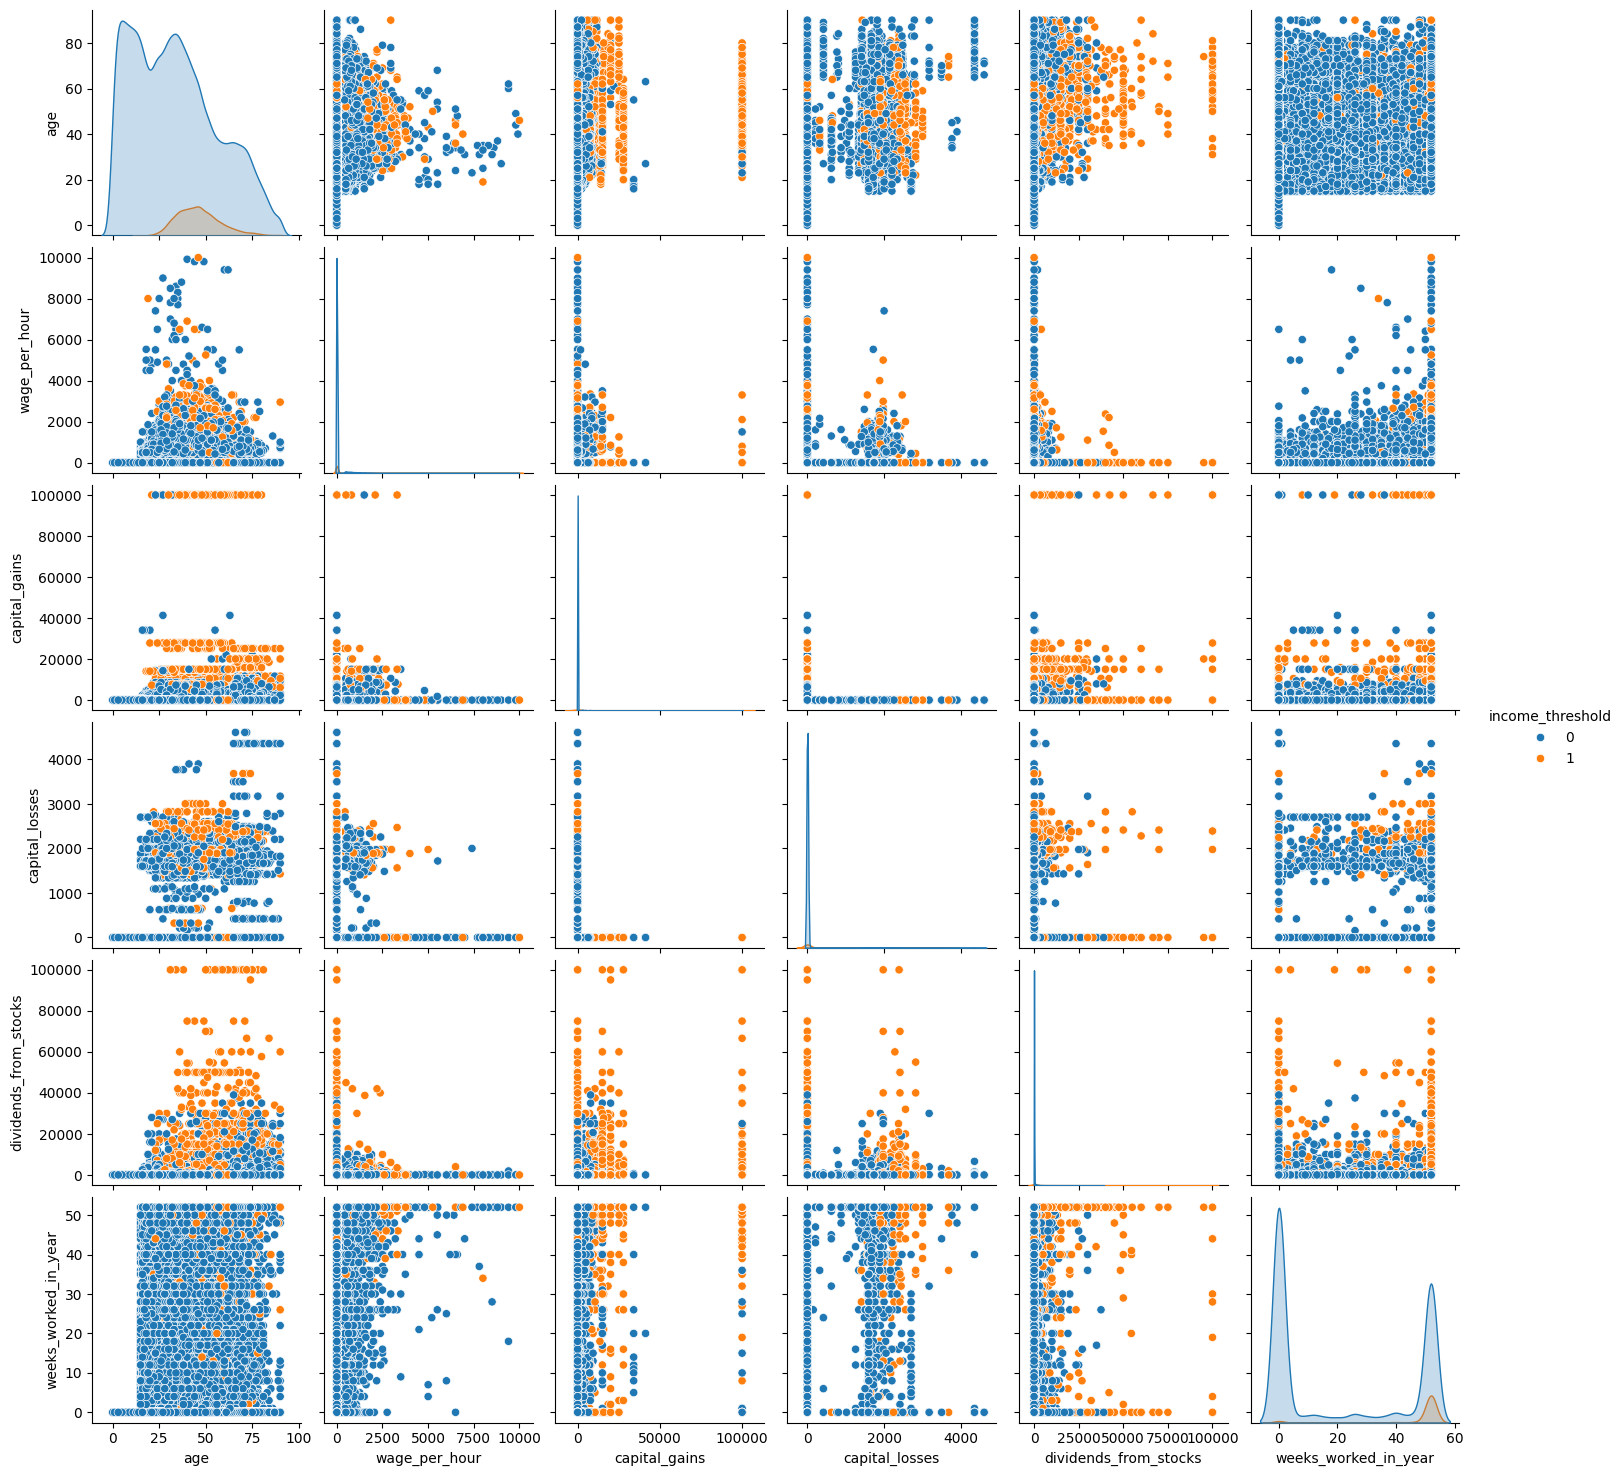

In [ ]:
num_features = [
	'age',
	'wage_per_hour',
	'capital_gains',
	'capital_losses',
	'dividends_from_stocks',
	'weeks_worked_in_year',
	'income_threshold',
]

sns.pairplot(data[num_features], hue='income_threshold')

In [2]:
corr_matrix = data[num_features].corr()
corr_matrix['income_threshold'].sort_values(ascending=False)

income_threshold         1.000000
weeks_worked_in_year     0.262316
capital_gains            0.240725
dividends_from_stocks    0.175779
capital_losses           0.147417
age                      0.135720
wage_per_hour            0.024528
Name: income_threshold, dtype: float64

Interestingly wage_per_hour, which intuitively should have a large positive linear correlation with income, does seem to have any significant correlation.

In [3]:
# explore ditribution of wage_per_hour in the dataset

data.wage_per_hour.value_counts() / len(data)

wage_per_hour
0       0.943345
500     0.003679
600     0.002737
700     0.002676
800     0.002541
          ...   
3846    0.000005
1224    0.000005
548     0.000005
260     0.000005
1752    0.000005
Name: count, Length: 1240, dtype: float64

This analysis shows that 94% respondents have 0 hourly wage, resulting in the low linear correlation with income_threshold.

This may be due to the majority of workers recieving an annual salary instead of an hourly one.

Splitting wage_per_hour into bins may be more useful to the model.


In [13]:
data = data.assign(
	wage_per_hour=lambda x: np.select(
		condlist=[x['wage_per_hour'] == 0, x['wage_per_hour'] > 500],
		choicelist=['0', '500+'],
		default='0-500',
	)
)

data.wage_per_hour.value_counts() / len(data)

wage_per_hour
0        0.943345
500+     0.046295
0-500    0.010360
Name: count, dtype: float64

### Correlations with categorical variables


c:\Users\Nick\miniconda3\envs\ml\Lib\site-packages\pandas\plotting\_matplotlib\core.py:580: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = self.plt.figure(figsize=self.figsize)


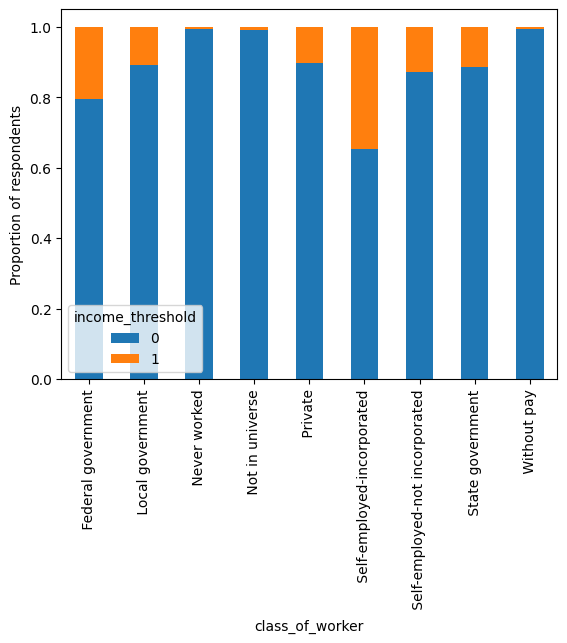

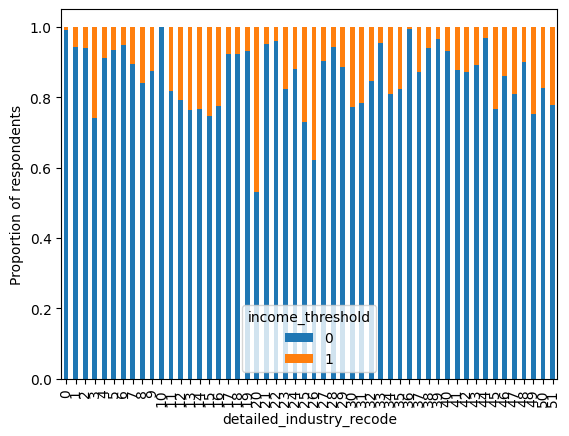

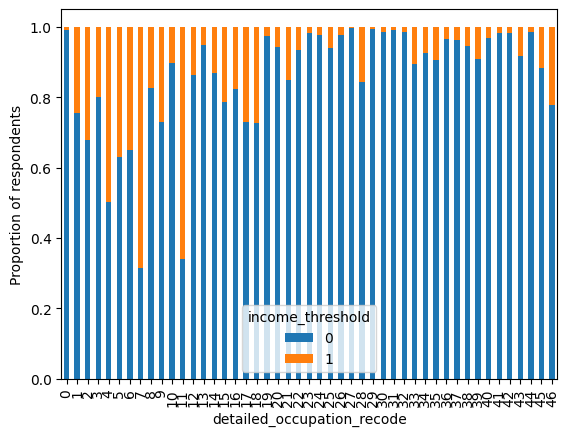

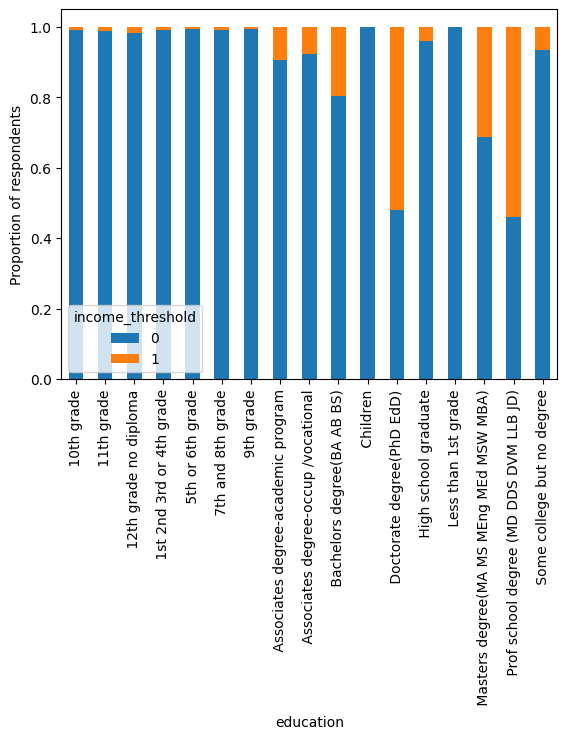

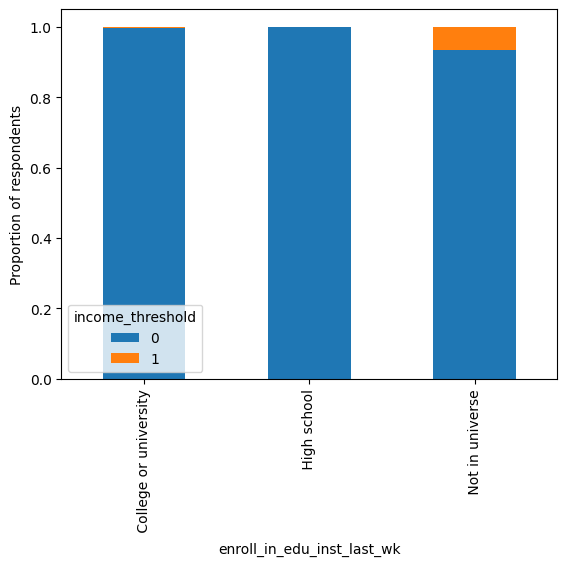

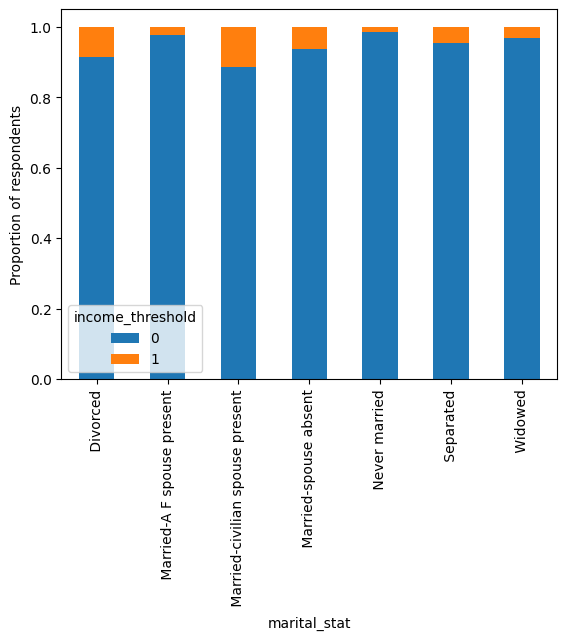

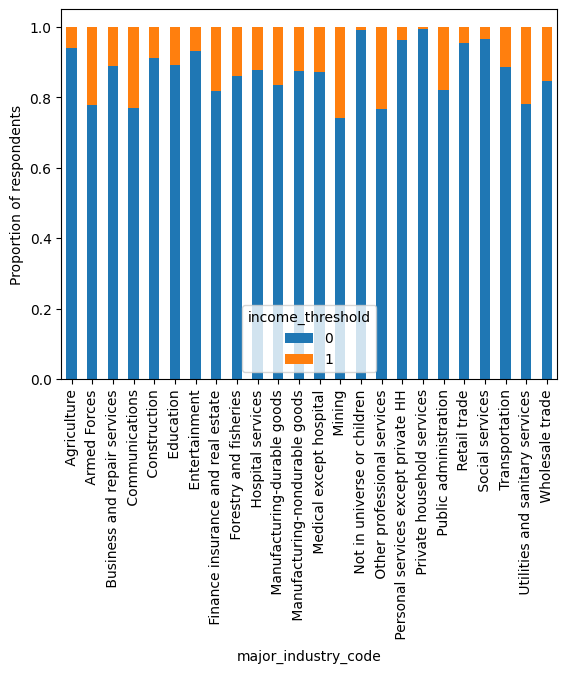

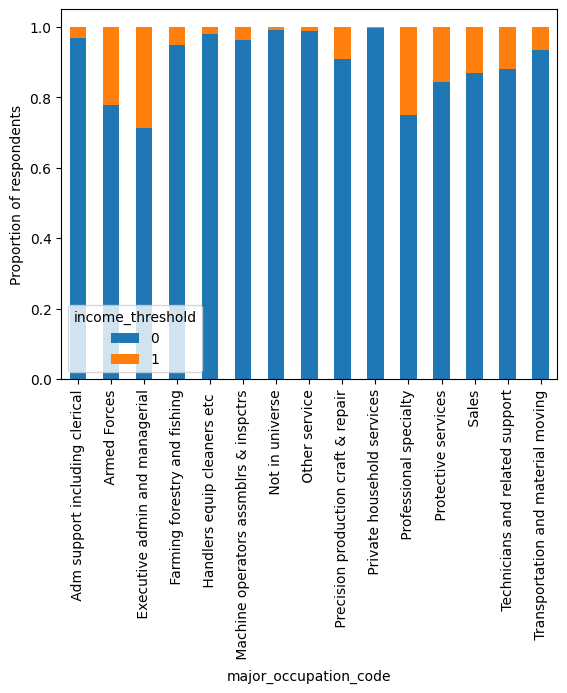

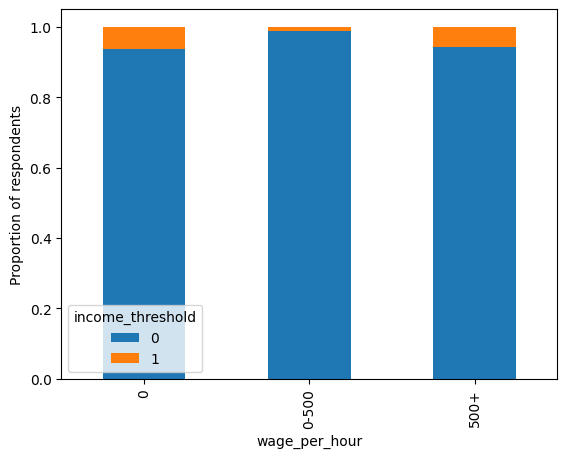

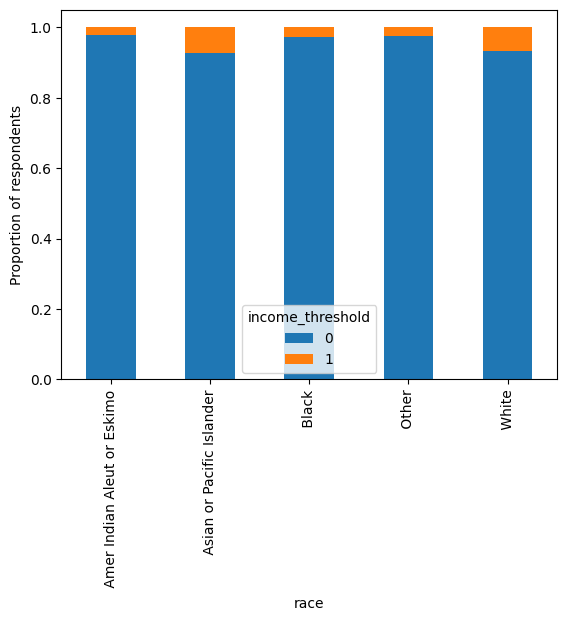

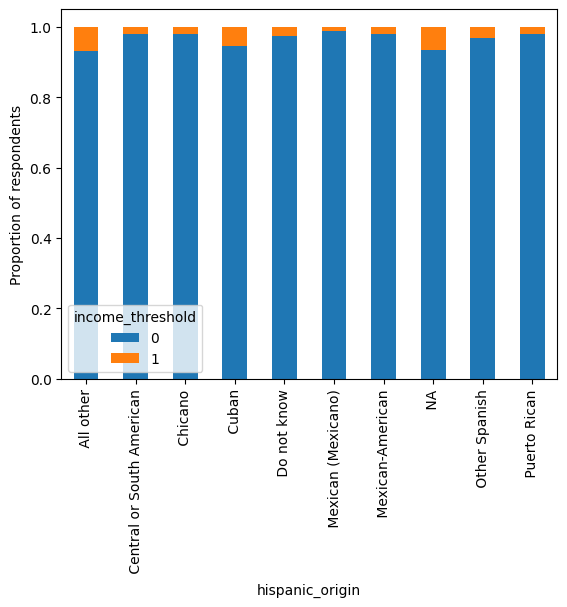

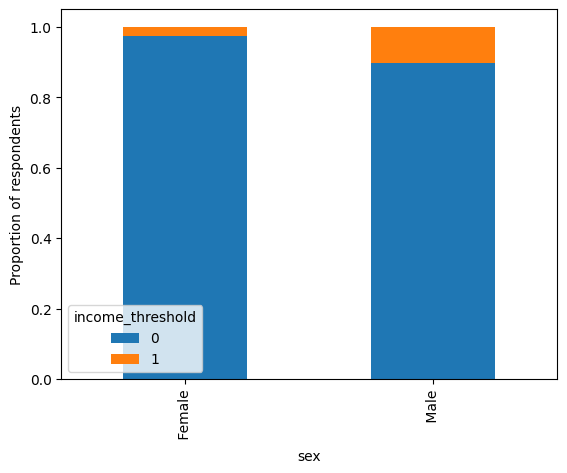

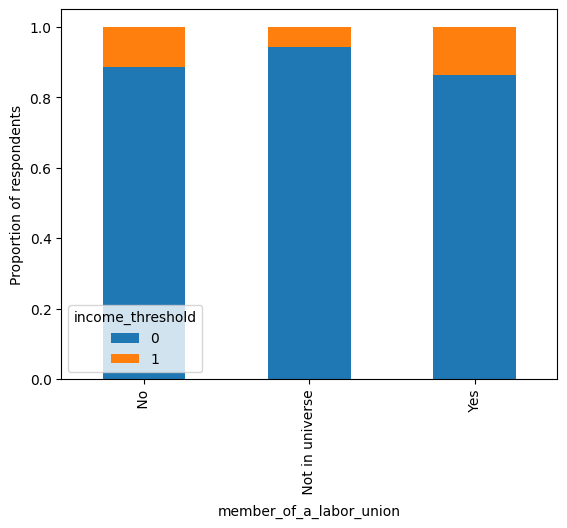

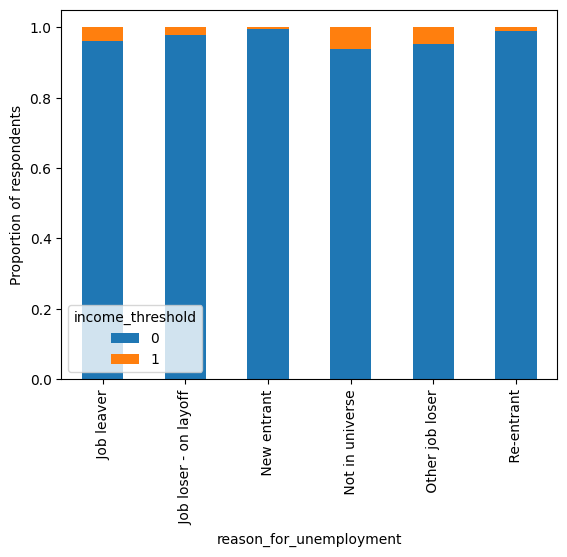

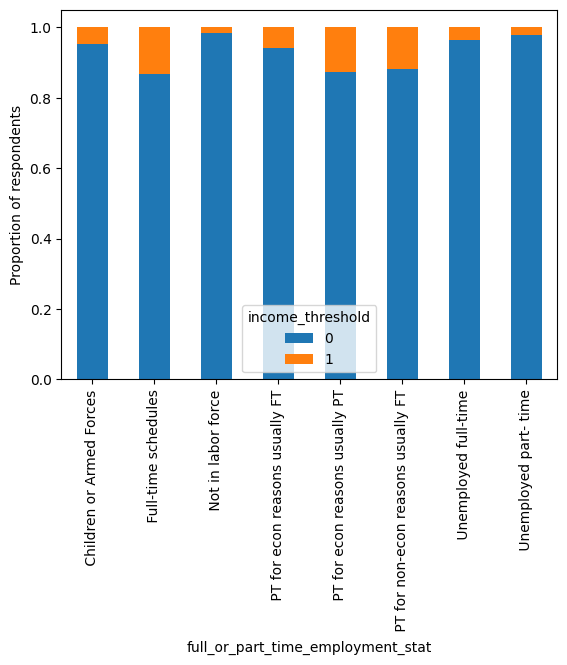

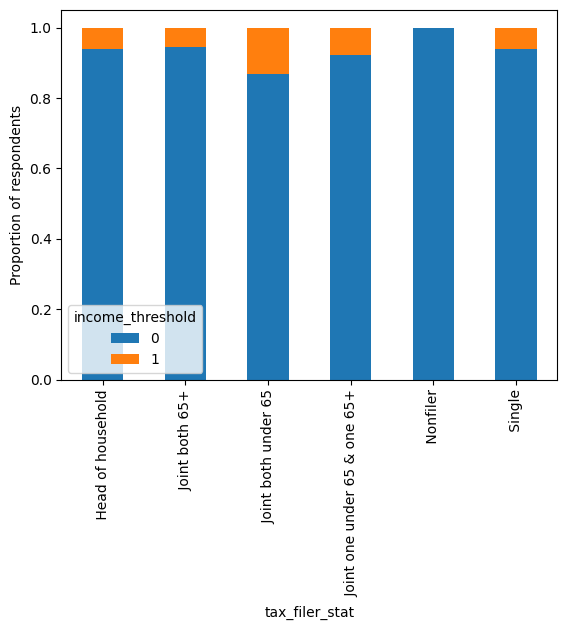

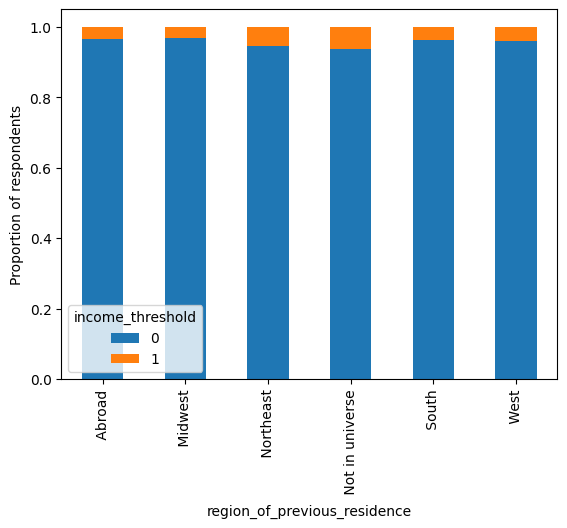

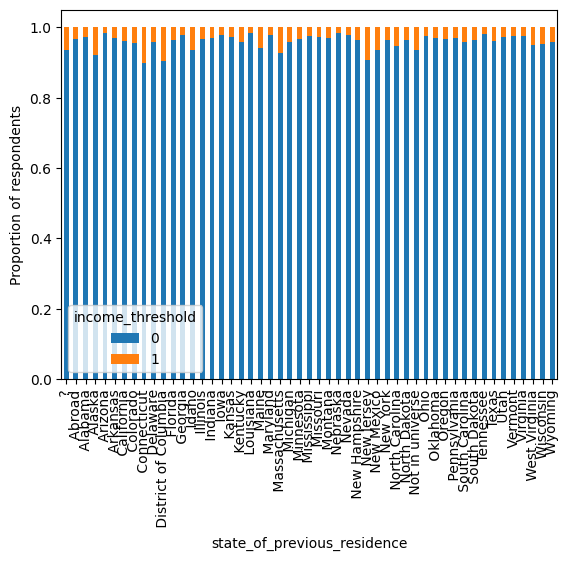

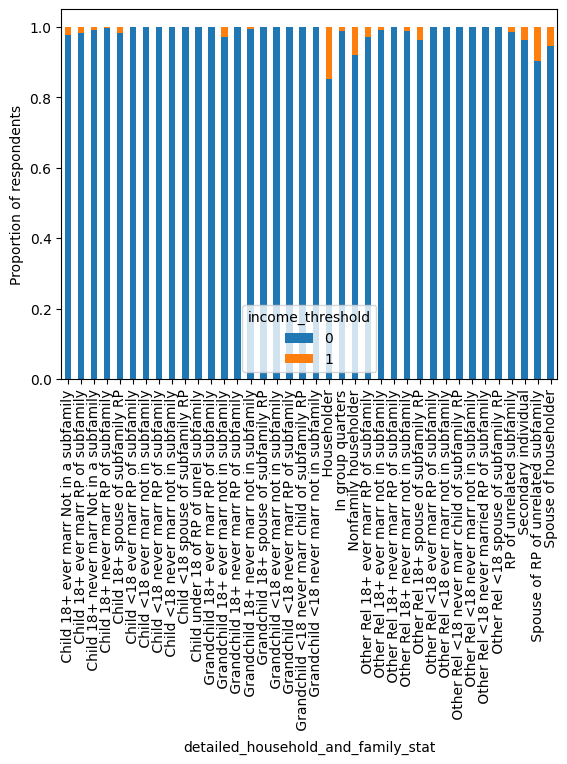

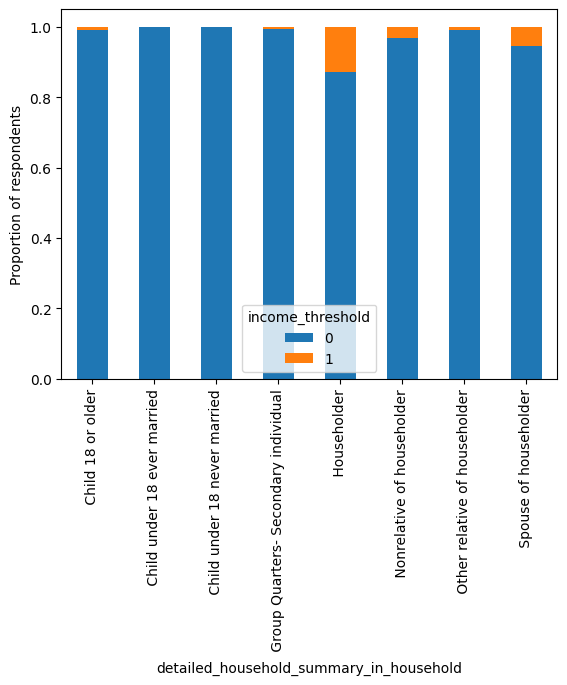

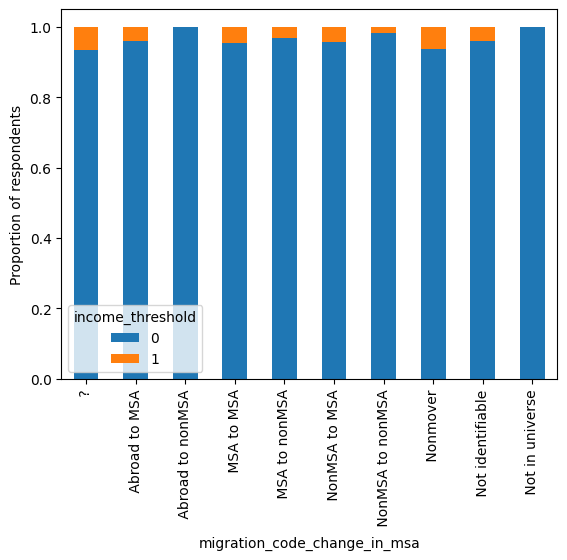

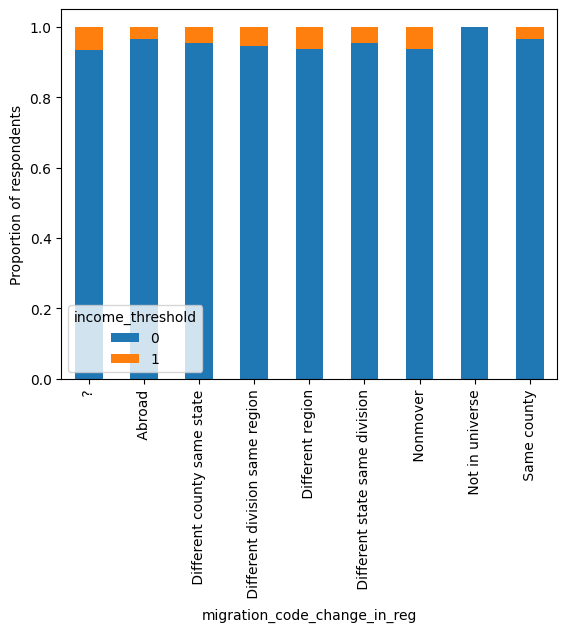

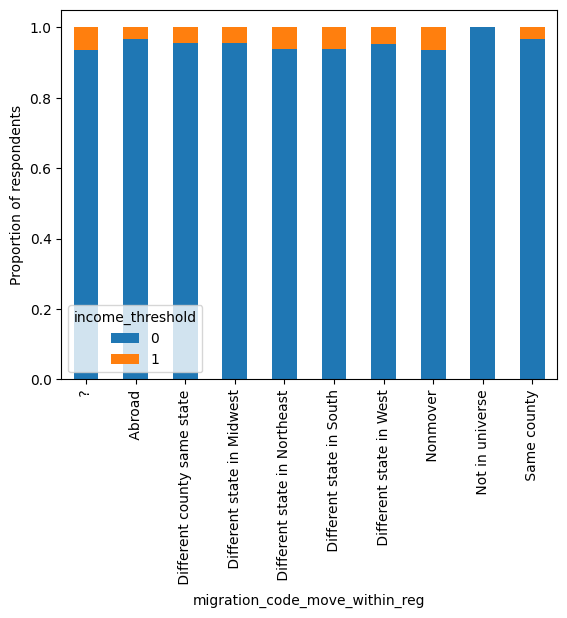

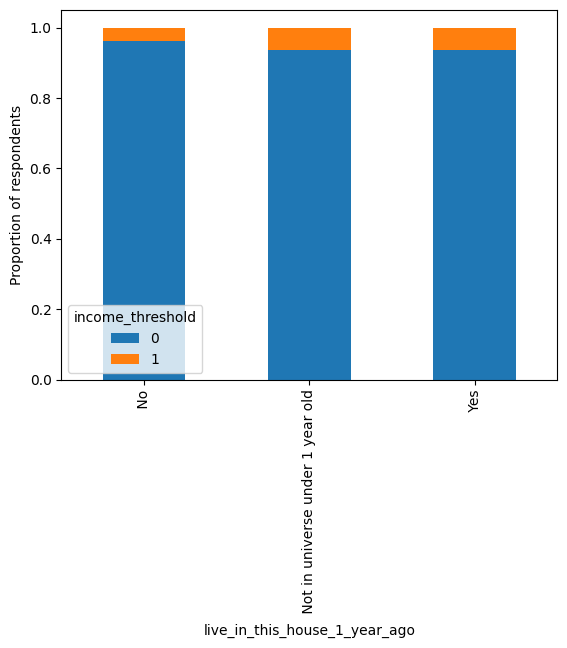

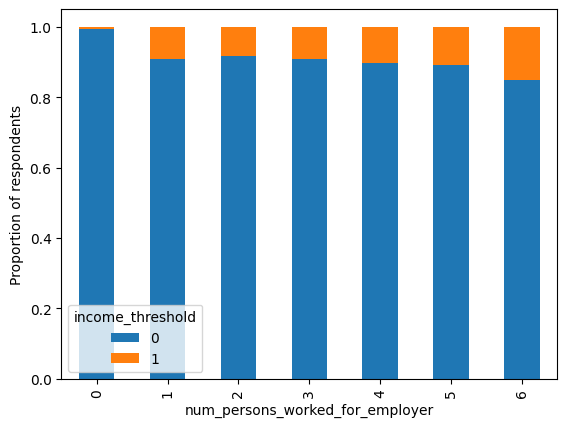

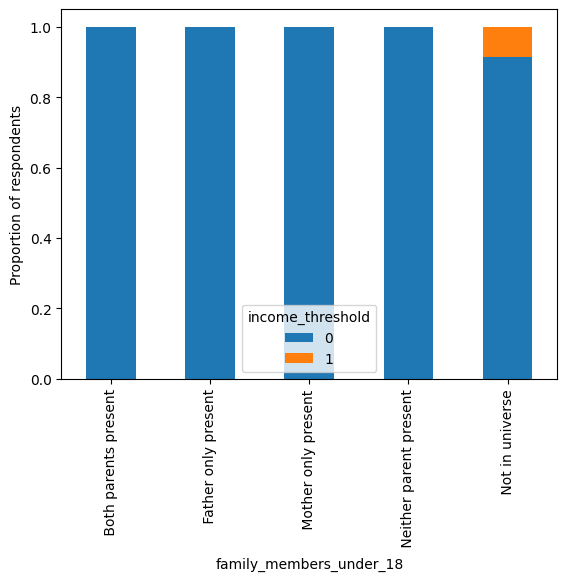

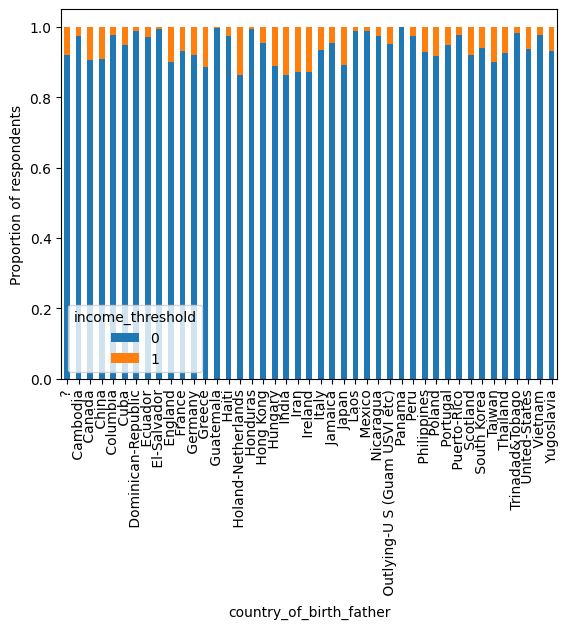

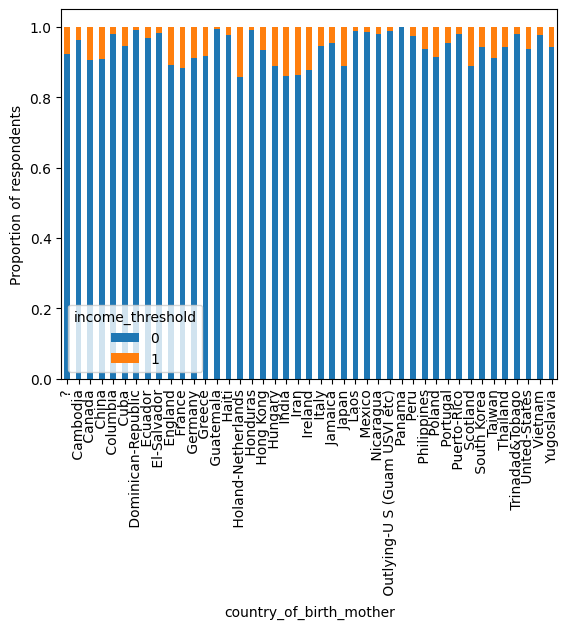

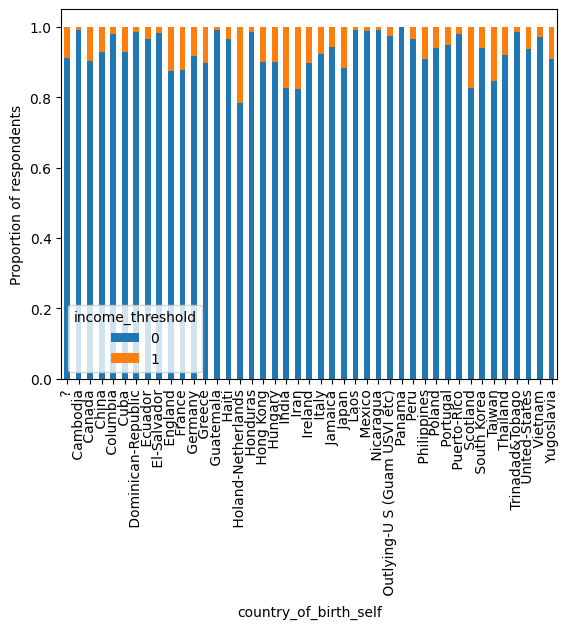

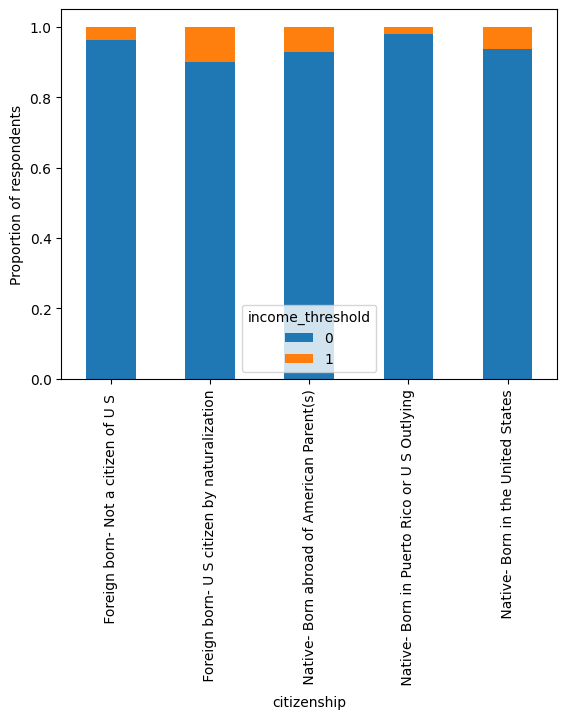

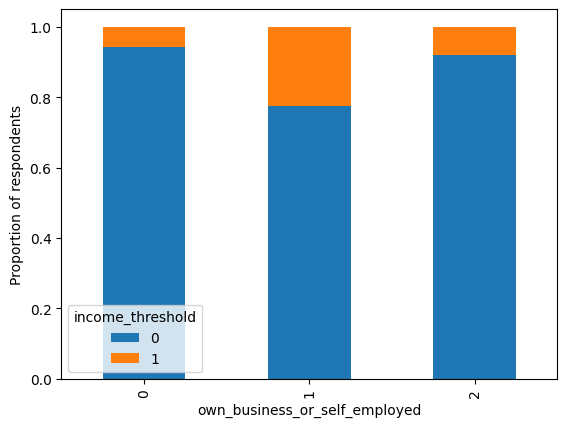

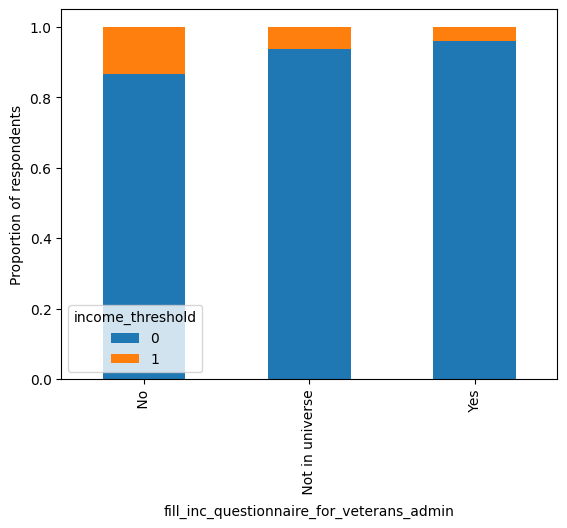

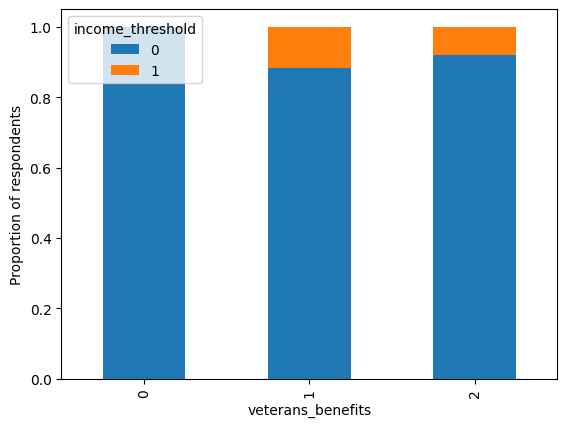

In [14]:
cat_features = [
	'class_of_worker',
	'detailed_industry_recode',
	'detailed_occupation_recode',
	'education',
	'enroll_in_edu_inst_last_wk',
	'marital_stat',
	'major_industry_code',
	'major_occupation_code',
	'wage_per_hour',
	'race',
	'hispanic_origin',
	'sex',
	'member_of_a_labor_union',
	'reason_for_unemployment',
	'full_or_part_time_employment_stat',
	'tax_filer_stat',
	'region_of_previous_residence',
	'state_of_previous_residence',
	'detailed_household_and_family_stat',
	'detailed_household_summary_in_household',
	'migration_code_change_in_msa',
	'migration_code_change_in_reg',
	'migration_code_move_within_reg',
	'live_in_this_house_1_year_ago',
	'num_persons_worked_for_employer',
	'family_members_under_18',
	'country_of_birth_father',
	'country_of_birth_mother',
	'country_of_birth_self',
	'citizenship',
	'own_business_or_self_employed',
	'fill_inc_questionnaire_for_veterans_admin',
	'veterans_benefits',
]

for feature in cat_features:
	(
		data.groupby(feature)['income_threshold']
		.value_counts(normalize=True)
		.unstack('income_threshold')
		.plot.bar(stacked=True)
		.set_ylabel('Proportion of respondents')
	)


Inspecting these plots found an issue with family_members_under_18 as all of respondents over the income threshold were 'not in universe'.

This is explained by the additional information, as the universe is under 18's only. This information can better be captured with a binary is_child feature.

Note: This column has been incorrectly labelled in the metadata as 'family members under 18' when it should be 'presence of parents'.

### Not in universe

Large proportions of some features are labelled as 'not in universe'. Should these be treated as NAs? The metadata suggests that some survey questions are not applicable to certain observations because they are children or pensioners. These may therefore contatain predictive value and imputing he values would be removing information from the dataset.

I'll create a new categorical variable to detect working age and determine whether this explains the majority of the 'not in universe' values. 

The US Department of Labour restricts working hours for under 16 year olds, so I will use that as the maximum age for a child. I'll use 67 as a the cut off for a person of retirement age as 67 is [USA 'Normal Retirement Age'](https://www.ssa.gov/oact/progdata/nra.html).



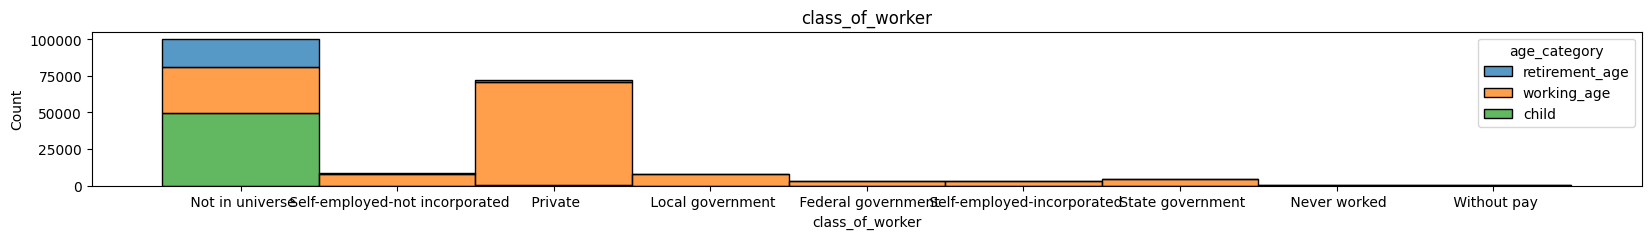

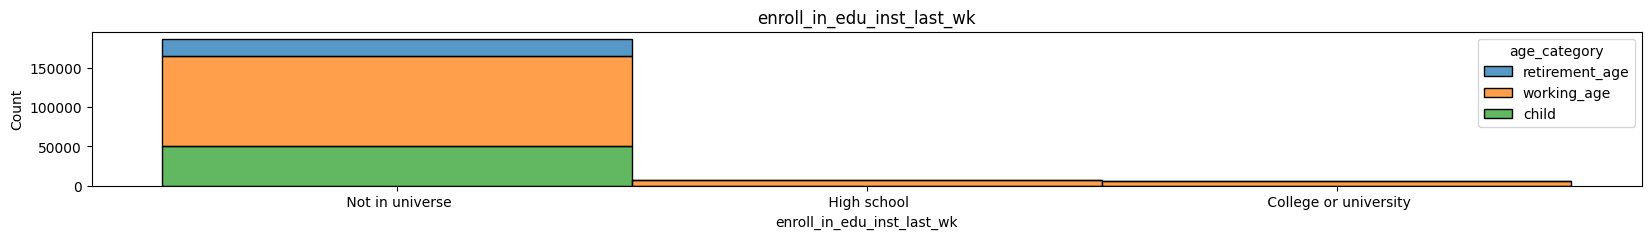

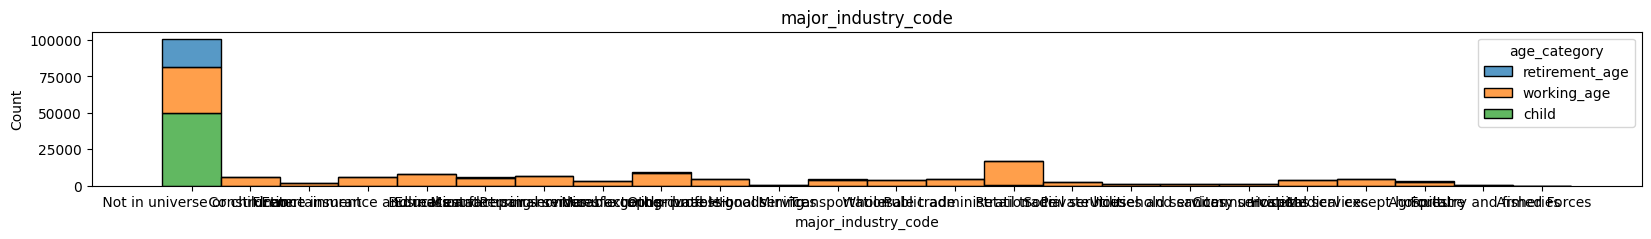

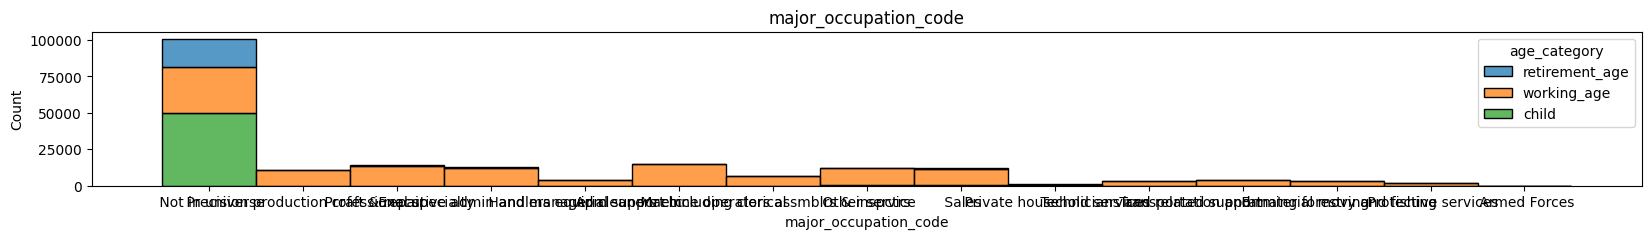

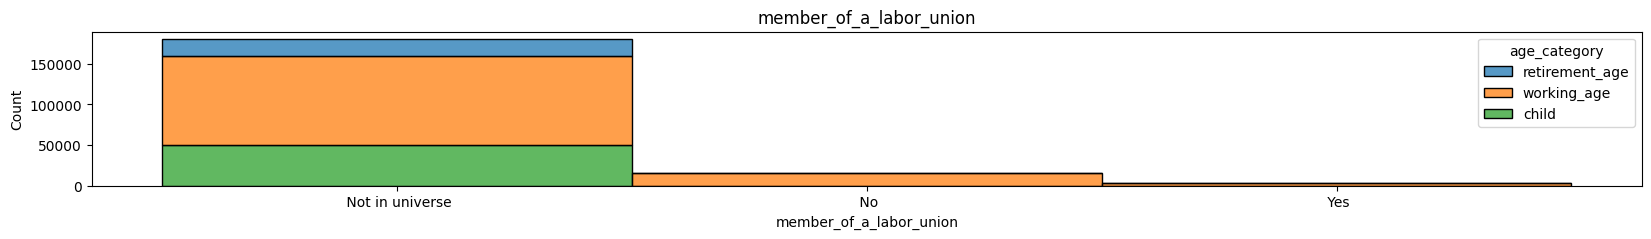

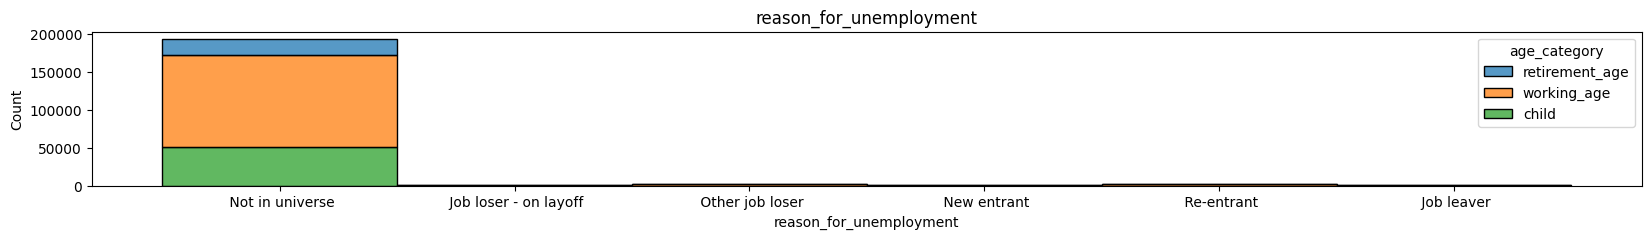

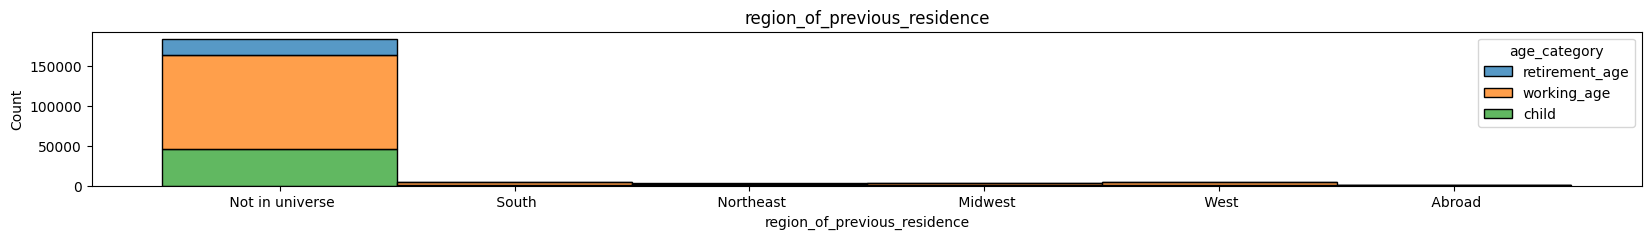

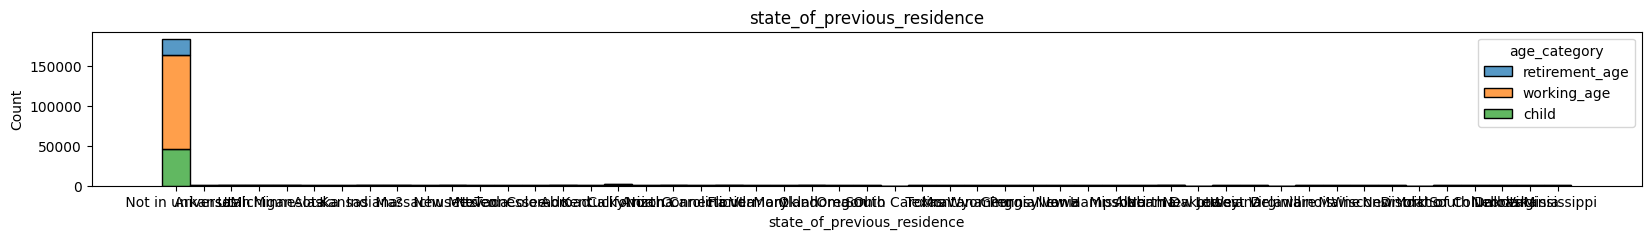

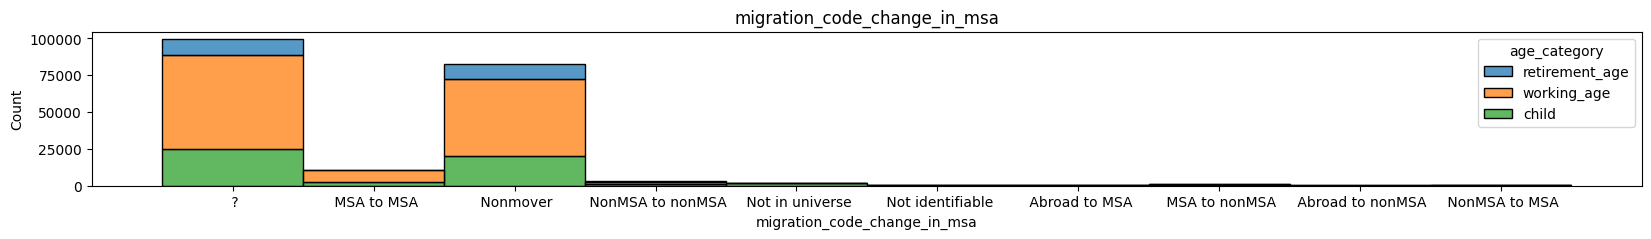

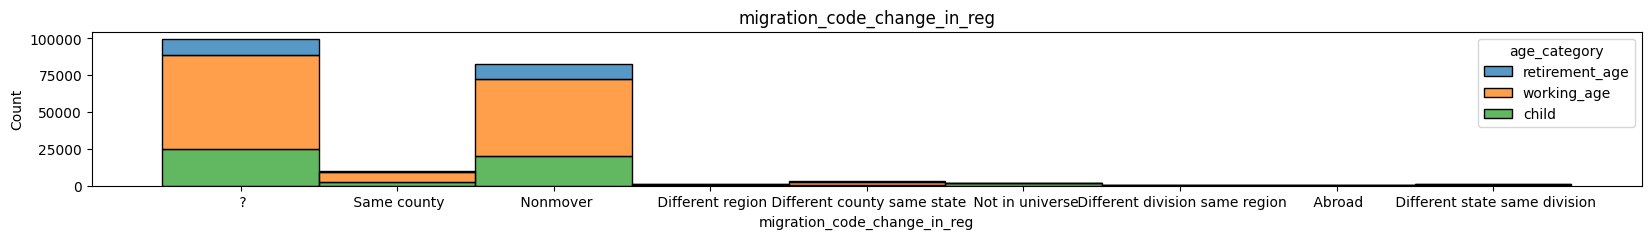

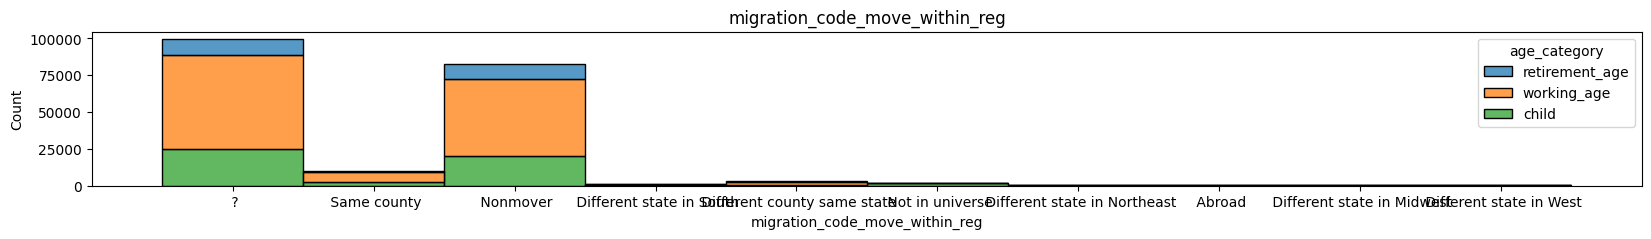

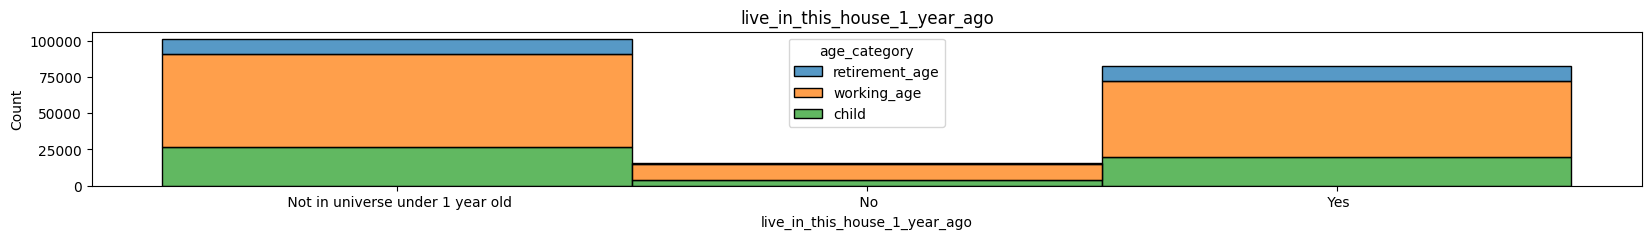

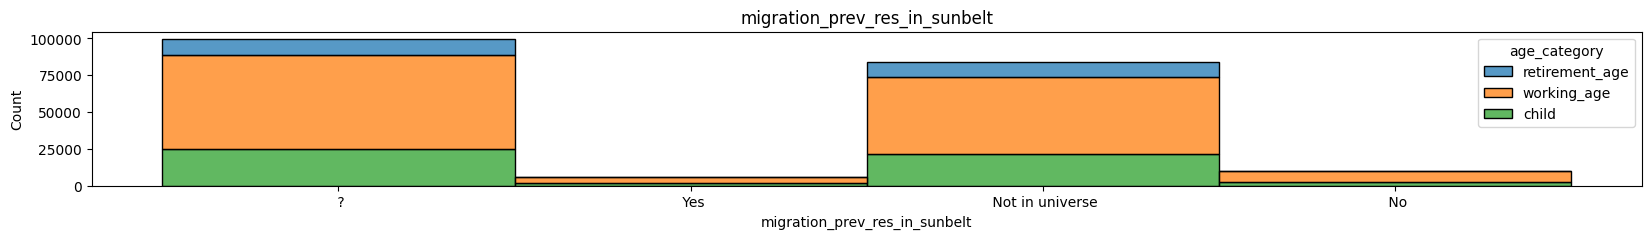

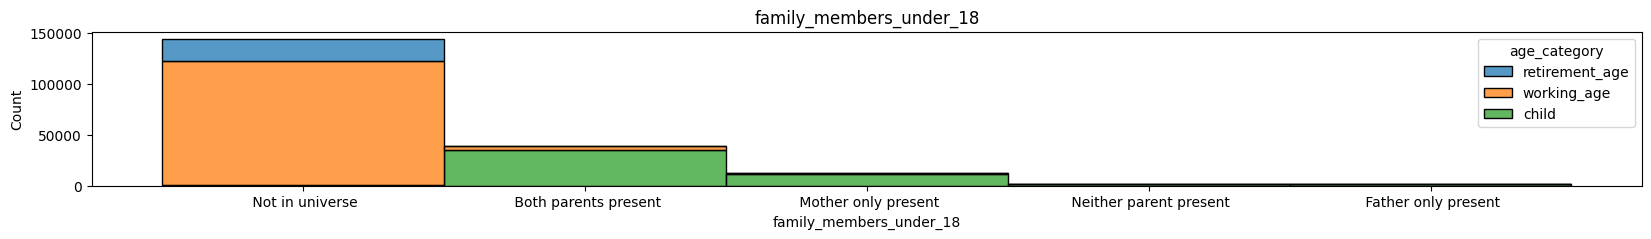

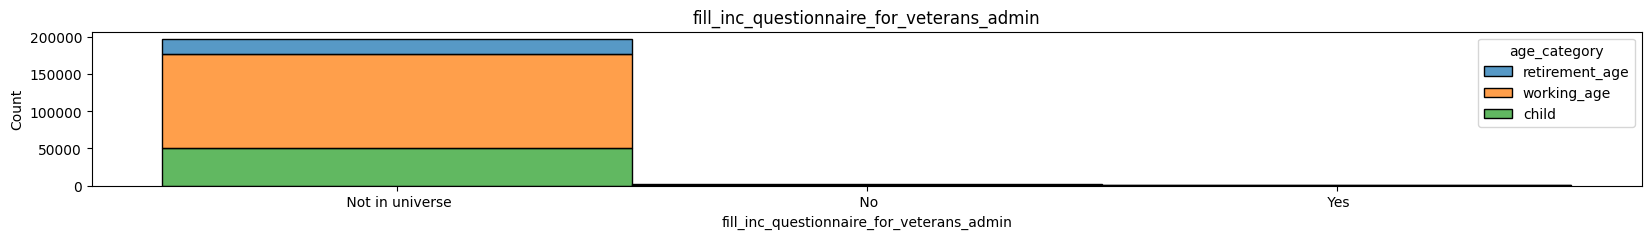

In [2]:
# Exporing Not in Universe (NIU) values

data = data.assign(
	age_category=lambda x: np.select(
		condlist=[x['age'] < 16, x['age'] >= 67],
		choicelist=['child', 'retirement_age'],
		default='working_age',
	)
)

niu_features = [
	'class_of_worker',
	'enroll_in_edu_inst_last_wk',
	'major_industry_code',
	'major_occupation_code',
	'member_of_a_labor_union',
	'reason_for_unemployment',
	'region_of_previous_residence',
	'state_of_previous_residence',
	'migration_code_change_in_msa',
	'migration_code_change_in_reg',
	'migration_code_move_within_reg',
	'live_in_this_house_1_year_ago',
	'migration_prev_res_in_sunbelt',
	'family_members_under_18',
	'fill_inc_questionnaire_for_veterans_admin',
]

for feature in niu_features:
	plt.figure(figsize=(20, 2))
	plt.title(feature)
	sns.histplot(
		# binwidth=0.1,
		x=feature,
		hue='age_category',
		data=data,
		stat='count',
		multiple='stack',
	)

plt.show()


These plots show that working age is highly correlated with NIU values for most features, however a significant proportion of NIU values are of working age. 

This makes sense for some features eg. veteran benefits would not be applicable to all non-veterans in addition to children. 

NIU values should therefore not be imputed as they are not evenly distributed across the dataset and are more likely to indicate that the respondent is not of working age. Including age_category as a feature should help the model identify these patterns in the dataset. 


### Pre-processing required
---

#### Features to drop

**family_members_under_18 (should be presence_of_parents)**: previously discussed, information best captured by working_age_category feature

**fill_inc_questionnaire_for_veterans_admin**: information better captured by veterans_benefits

**instance_weight**: told to ignore in metadata

**year**: differences in years not relevant this use-case

---

#### New features

**age_binned**
* age <= 16 : child
* age >= 67: retirement_age
* 16 < age < 67: working_age

---

#### Binning existing features to reduce imbalance and noise to prevent overfitting

Decisions made based on observing the distributon of the target in the categorical variables in the above plots, aiming to preserve information

**education**
* Child, High School Dropout, High School Graduate, Higher Education

**wage_per_hour**
* 0, 0-500, 500+

**marital_stat**
* combine married permutations into single value

**race**
* White, Black, Other

**reason_for_unemployment**
* NIU, Other

**full_or_part_time_employment_stat**
* Children or AF, Full-time, Not in Labour Force, Other

**citizenship**
* Native, Foreign Born

**weeks_worked_in_year**
* 0, 52, 0-52

---
#### Treating missing values

* hispanic origin: impute with most frequent (0.4% of the dataset)
* country_of_birth: impute with most frequent (~6% of the dataset)
* migration codes: treat '?' as own category

---
#### Scaling

Standard scaler will be used to scale all numeric variables.

#### OHE

OHE will be used to encode categorical variables.

### Balancing data

Oversampling using SMOTE will be used to balance the target class.